# LSTM Volatility Forecasting
In this notebook we test LSTM-based volatility forecasting against traditional GARCH baselines.  


We import:
- `torch`, `numpy`, `pandas`, `matplotlib` for modeling and analysis  
- `sklearn.metrics` for RMSE/MAE evaluation  
- Project utilities:  
  - `fetch_yf` and `multi_fetch` for data  
  - `LSTMForecaster` and datasets for model training  
  - `metrics` and `rolling_garch_forecast` for baseline evaluation  

In [ ]:
import sys, os
sys.path.append(os.path.abspath(".."))

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from torch.utils.data import random_split, DataLoader, Dataset

from volsense_core.data_fetching.fetch_yf import fetch_ohlcv, compute_returns_vol
from volsense_core.data_fetching.multi_fetch import fetch_multi_ohlcv, build_multi_dataset
from volsense_core.models.lstm_forecaster import MultiVolDataset, LSTMForecaster, train_lstm, evaluate_lstm
from volsense_core.utils.metrics import evaluate_forecasts
from volsense_core.utils.metrics import rolling_garch_forecast

# Single-Ticker Dataset Preparation (SPY)
We start with **SPY** (S&P500) as a benchmark:
- Fetch OHLCV data since 1990  
- Compute returns and realized volatility (21-day rolling window)  
- Build a supervised dataset using a sliding window (30-day input → 1-day ahead target)  
- Split into train/validation sets  


In [4]:
# === Inline dataset class for single-ticker ===
class VolDataset(Dataset):
    def __init__(self, series: np.ndarray, window: int = 30, horizon: int = 1):
        self.series = np.array(series)
        self.window = window
        self.horizon = horizon

    def __len__(self):
        return len(self.series) - self.window - self.horizon

    def __getitem__(self, idx):
        x = self.series[idx:idx + self.window]
        y = self.series[idx + self.window + self.horizon - 1]
        # reshape x to (window, 1) so LSTM sees input_size=1
        x = torch.tensor(x, dtype=torch.float32).unsqueeze(-1)
        y = torch.tensor(y, dtype=torch.float32)
        return x, y


# === Data ===
df = fetch_ohlcv("SPY", start="1990-01-01")
df = compute_returns_vol(df, window=21, ticker="SPY")
series = df["vol_realized"].dropna().values

# === Dataset ===
window = 30
dataset = VolDataset(series, window=window, horizon=1)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64)

c:\Users\rahul\OneDrive\Documents\GitHub\VolSense\volsense_pkg\data_fetching\fetch_yf.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end)
[*********************100%***********************]  1 of 1 completed


# LSTM Model: Training on SPY
We define and train a 2-layer LSTM forecaster with dropout:
- Hidden dim = 64, Dropout = 0.2  
- Optimized with Adam for 20 epochs  
After training, we evaluate the model on the validation set using RMSE.  

In [5]:
# === Model ===
device = "cuda" if torch.cuda.is_available() else "cpu"
model = LSTMForecaster(hidden_dim=64, num_layers=2, dropout=0.2)

# === Train ===
model = train_lstm(model, train_loader, val_loader, epochs=20, lr=1e-3, device=device)

# === Save checkpoint ===
os.makedirs("checkpoints", exist_ok=True)
torch.save(model.state_dict(), "checkpoints/lstm_single.pth")
print("✅ Saved single-ticker LSTM to checkpoints/lstm_single.pth")

# === Evaluate ===
preds, actuals = evaluate_lstm(model, val_loader, device=device)
rmse = np.sqrt(mean_squared_error(actuals, preds))
print(f"LSTM RMSE: {rmse:.4f}")

Epoch 1/20 | Train Loss: 0.0071 | Val Loss: 0.0014
Epoch 2/20 | Train Loss: 0.0011 | Val Loss: 0.0008
Epoch 3/20 | Train Loss: 0.0007 | Val Loss: 0.0005
Epoch 4/20 | Train Loss: 0.0006 | Val Loss: 0.0004
Epoch 5/20 | Train Loss: 0.0005 | Val Loss: 0.0004
Epoch 6/20 | Train Loss: 0.0005 | Val Loss: 0.0004
Epoch 7/20 | Train Loss: 0.0004 | Val Loss: 0.0004
Epoch 8/20 | Train Loss: 0.0004 | Val Loss: 0.0003
Epoch 9/20 | Train Loss: 0.0004 | Val Loss: 0.0004
Epoch 10/20 | Train Loss: 0.0004 | Val Loss: 0.0003
Epoch 11/20 | Train Loss: 0.0003 | Val Loss: 0.0003
Epoch 12/20 | Train Loss: 0.0003 | Val Loss: 0.0004
Epoch 13/20 | Train Loss: 0.0003 | Val Loss: 0.0003
Epoch 14/20 | Train Loss: 0.0003 | Val Loss: 0.0003
Epoch 15/20 | Train Loss: 0.0003 | Val Loss: 0.0003
Epoch 16/20 | Train Loss: 0.0003 | Val Loss: 0.0002
Epoch 17/20 | Train Loss: 0.0003 | Val Loss: 0.0003
Epoch 18/20 | Train Loss: 0.0003 | Val Loss: 0.0002
Epoch 19/20 | Train Loss: 0.0002 | Val Loss: 0.0002
Epoch 20/20 | Train L

# Forecast Evaluation – SPY
We visualize results:
- Compare realized volatility vs LSTM forecast  
- Plot error distribution to check for bias and variance  
This helps verify whether the LSTM tracks volatility dynamics effectively.  

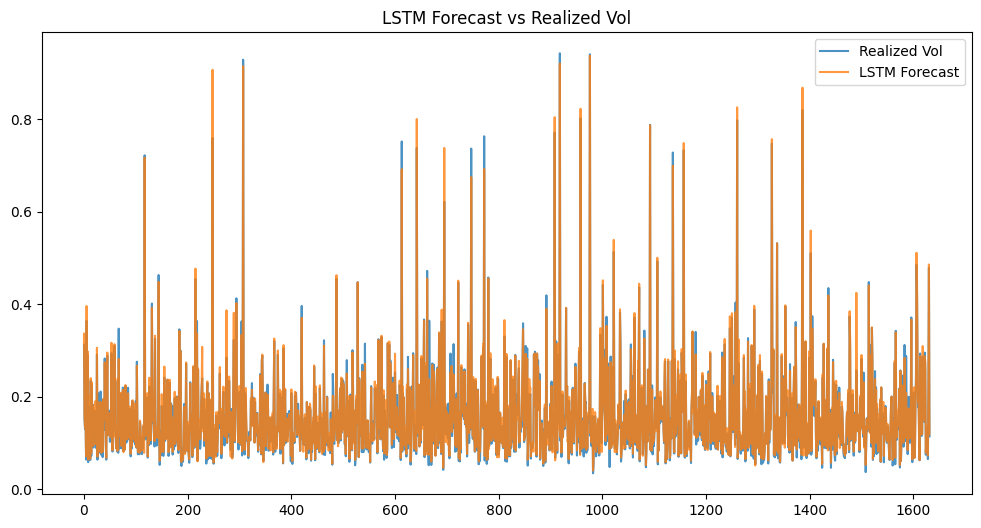

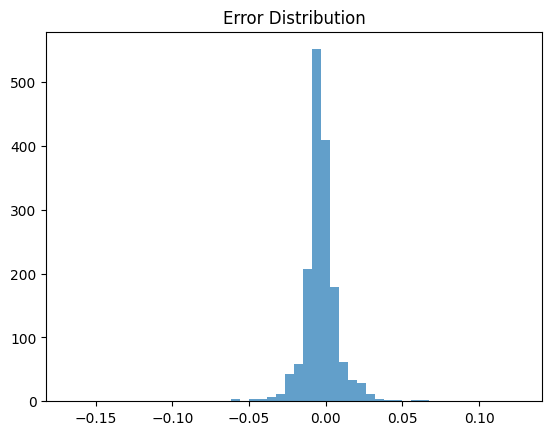

In [6]:
plt.figure(figsize=(12,6))
plt.plot(actuals, label="Realized Vol", alpha=0.8)
plt.plot(preds, label="LSTM Forecast", alpha=0.8)
plt.legend()
plt.title("LSTM Forecast vs Realized Vol")
plt.show()

errors = actuals - preds
plt.hist(errors, bins=50, alpha=0.7)
plt.title("Error Distribution")
plt.show()

# Multi-Ticker Dataset & Training
To improve generalization, we expand to multiple assets (SPY, AAPL, MSFT, TSLA, GOOG).  
Steps:
1. Fetch historical OHLCV data for all tickers  
2. Compute returns + realized vol  
3. Merge into a long-format dataset with a `ticker` column  
4. Train a new LSTM forecaster on this joint dataset  
This allows the model to learn cross-asset volatility patterns.  

In [8]:
# === Fetch Multi-Ticker Data ===
tickers = ["SPY", "AAPL", "MSFT", "TSLA", "GOOG"]
data_dict = fetch_multi_ohlcv(tickers, start="2000-01-01")
multi_df = build_multi_dataset(data_dict)

print(multi_df.head())

# === Dataset ===
window = 30
dataset = MultiVolDataset(multi_df, window=window, horizon=1)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=128)

# === Model ===
device = "cuda" if torch.cuda.is_available() else "cpu"
model = LSTMForecaster(hidden_dim=64, num_layers=2, dropout=0.2)

# === Train ===
model = train_lstm(model, train_loader, val_loader, epochs=20, lr=1e-3, device=device)

# === Save checkpoint ===
os.makedirs("checkpoints", exist_ok=True)
torch.save(model.state_dict(), "checkpoints/lstm_multi.pth")
print("✅ Saved multi-ticker LSTM to checkpoints/lstm_multi.pth")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Price        date    return realized_vol ticker
Ticker                                         
0      2000-02-02 -0.014339     0.841916   AAPL
1      2000-02-03  0.045541     0.806392   AAPL
2      2000-02-04  0.045372     0.819574   AAPL
3      2000-02-07  0.056134     0.770591   AAPL
4      2000-02-08  0.007124     0.758422   AAPL
Epoch 1/20 | Train Loss: 0.0160 | Val Loss: 0.0026
Epoch 2/20 | Train Loss: 0.0028 | Val Loss: 0.0021
Epoch 3/20 | Train Loss: 0.0022 | Val Loss: 0.0017
Epoch 4/20 | Train Loss: 0.0018 | Val Loss: 0.0014
Epoch 5/20 | Train Loss: 0.0015 | Val Loss: 0.0013
Epoch 6/20 | Train Loss: 0.0013 | Val Loss: 0.0011
Epoch 7/20 | Train Loss: 0.0011 | Val Loss: 0.0011
Epoch 8/20 | Train Loss: 0.0010 | Val Loss: 0.0010
Epoch 9/20 | Train Loss: 0.0010 | Val Loss: 0.0010
Epoch 10/20 | Train Loss: 0.0009 | Val Loss: 0.0011
Epoch 11/20 | Train Loss: 0.0009 | Val Loss: 0.0010
Epoch 12/20 | Train Loss: 0.0009 | Val Loss: 0.0010
Epoch 13/20 | Train Loss: 0.0009 | Val Loss: 0.00

# Evaluation: LSTM vs GARCH
We evaluate the multi-ticker LSTM and compare against a GARCH(1,1) baseline:
- **Step 1:** Evaluate LSTM forecasts (RMSE, MAE)  
- **Step 2:** Fit rolling GARCH forecasts on SPY for comparison  
- **Step 3:** Plot realized vs forecast vol for both methods  
- **Step 4:** Compare error distributions (LSTM vs GARCH)  
This highlights the advantage of deep learning models vs traditional econometric baselines.  

LSTM RMSE: 0.0324 | MAE: 0.0140
GARCH RMSE: 0.1306 | MAE: 0.0937


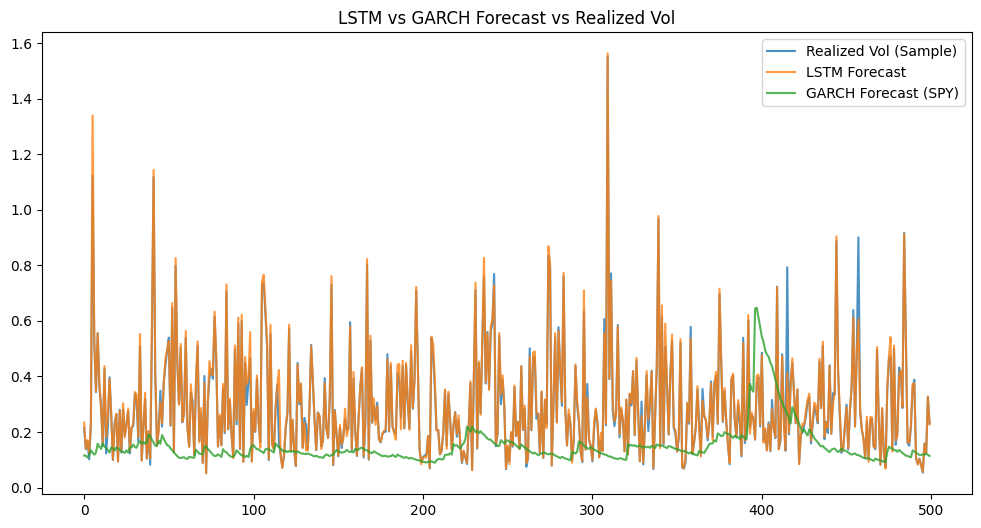

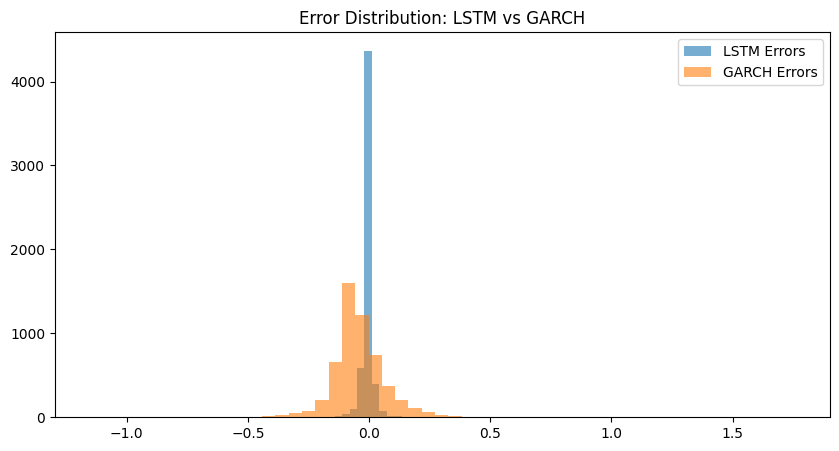

In [9]:
# === 1. Evaluate LSTM ===
preds, actuals = evaluate_lstm(model, val_loader, device=device)
lstm_rmse = np.sqrt(mean_squared_error(actuals, preds))
lstm_mae = np.mean(np.abs(actuals - preds))
print(f"LSTM RMSE: {lstm_rmse:.4f} | MAE: {lstm_mae:.4f}")

# === 2. Evaluate GARCH baseline (on SPY only for speed) ===
spy_df = multi_df[multi_df["ticker"] == "SPY"].copy()
returns = spy_df["return"].dropna()

garch_results = rolling_garch_forecast(returns, window=1000, horizon=1)
garch_metrics = evaluate_forecasts(garch_results)
print(f"GARCH RMSE: {garch_metrics['RMSE']:.4f} | MAE: {garch_metrics['MAE']:.4f}")

# === 3. Plot Comparison ===
plt.figure(figsize=(12,6))
plt.plot(actuals[:500], label="Realized Vol (Sample)", alpha=0.8)
plt.plot(preds[:500], label="LSTM Forecast", alpha=0.8)
plt.plot(garch_results["forecast_vol"].iloc[-500:].values, 
         label="GARCH Forecast (SPY)", alpha=0.8)
plt.legend()
plt.title("LSTM vs GARCH Forecast vs Realized Vol")
plt.show()

# === 4. Error Distribution Comparison ===
lstm_errors = actuals - preds
garch_errors = garch_results["realized_vol"].dropna().values - garch_results["forecast_vol"].dropna().values

plt.figure(figsize=(10,5))
plt.hist(lstm_errors, bins=50, alpha=0.6, label="LSTM Errors")
plt.hist(garch_errors, bins=50, alpha=0.6, label="GARCH Errors")
plt.legend()
plt.title("Error Distribution: LSTM vs GARCH")
plt.show()

In [1]:
# =====================================================
# ✅ Quick Test for BaseLSTMv2 (single-ticker prototype)
# =====================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from volsense_core.models.lstm_forecaster import TrainConfig, train_baselstm
from volsense_core.data_fetching.fetch_yf import fetch_ohlcv, compute_returns_vol
from volsense_core.data_fetching.feature_engineering import build_features

In [2]:
# --------------------------
# 1️⃣ Fetch and preprocess data
# --------------------------
TICKER = "AAPL"
print(f"🔍 Fetching {TICKER} historical data...")
raw_df = fetch_ohlcv(TICKER, start="2005-01-01", end="2024-12-31")
raw_df = compute_returns_vol(raw_df, window=21, ticker=TICKER)
multi_df = build_features(raw_df)

# Ensure necessary columns exist
assert "realized_vol" in multi_df.columns, "Missing realized_vol after feature engineering"
assert "return" in multi_df.columns, "Missing return after feature engineering"

🔍 Fetching AAPL historical data...


In [3]:
EPS = 1e-6
# Create log-vol column
multi_df["realized_log_vol"] = np.log(multi_df["realized_vol"].clip(lower=0) + EPS)

# Overwrite realized_vol with the log values
multi_df["realized_vol"] = multi_df["realized_log_vol"]

# Clean up infinities and NaNs from the transform
multi_df.replace([np.inf, -np.inf], np.nan, inplace=True)
multi_df.dropna(subset=["realized_log_vol"], inplace=True)


🚀 Training BaseLSTM | Horizons=[1, 5, 10] | Target=realized_vol
⚠️ Dropping constant features: ['market_stress', 'market_stress_1d_lag']
⚠️ Dropping constant features: ['market_stress', 'market_stress_1d_lag']


c:\Users\rahul\OneDrive\Documents\GitHub\VolSense\venv\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 1/25 | LR: 4.98e-04 | Train: 1.035099 | Val: 0.537358
Epoch 2/25 | LR: 4.92e-04 | Train: 0.755022 | Val: 0.468294
Epoch 3/25 | LR: 4.82e-04 | Train: 0.595775 | Val: 0.438061
Epoch 4/25 | LR: 4.69e-04 | Train: 0.498275 | Val: 0.417757
Epoch 5/25 | LR: 4.52e-04 | Train: 0.454232 | Val: 0.397063
Epoch 6/25 | LR: 4.32e-04 | Train: 0.429801 | Val: 0.401712
Epoch 7/25 | LR: 4.10e-04 | Train: 0.420904 | Val: 0.404602
Epoch 8/25 | LR: 3.84e-04 | Train: 0.414288 | Val: 0.413166
Epoch 9/25 | LR: 3.57e-04 | Train: 0.414097 | Val: 0.407651
Epoch 10/25 | LR: 3.28e-04 | Train: 0.401632 | Val: 0.390208
Epoch 11/25 | LR: 2.97e-04 | Train: 0.404510 | Val: 0.395880
Epoch 12/25 | LR: 2.66e-04 | Train: 0.393064 | Val: 0.396393
Epoch 13/25 | LR: 2.35e-04 | Train: 0.387695 | Val: 0.393891
Epoch 14/25 | LR: 2.04e-04 | Train: 0.387573 | Val: 0.397642
Epoch 15/25 | LR: 1.73e-04 | Train: 0.382986 | Val: 0.400862
Epoch 16/25 | LR: 1.44e-04 | Train: 0.386307 | Val: 0.398697
Epoch 17/25 | LR: 1.17e-04 | Trai

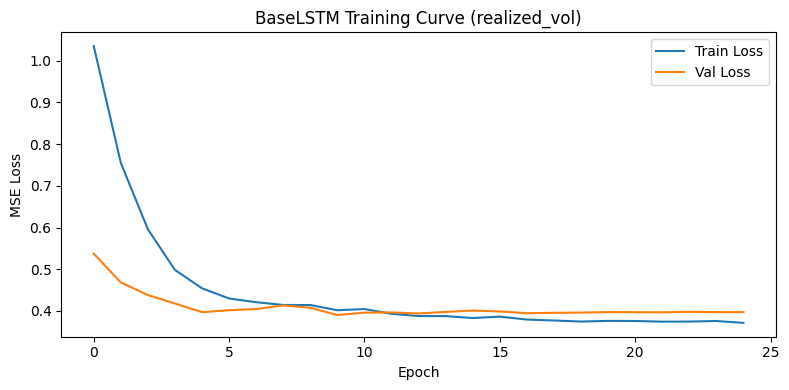

In [3]:
# ============================================
# 🚀 Train BaseLSTM on realized_vol
# ============================================
from volsense_core.models.lstm_forecaster import TrainConfig, train_baselstm

# --- 1️⃣ Configure training ---
cfg = TrainConfig(
    window=40,
    horizons=[1, 5, 10],
    val_start="2022-01-01",       # ensure validation slice exists
    target_col="realized_vol",    # using raw vol (not log)
    batch_size=256,
    epochs=25,
    lr=5e-4,
    weight_decay=1e-5,
    dropout=0.2,
    hidden_dim=128,
    num_layers=3,
    use_layernorm=True,
    use_attention=True,
    feat_dropout_p=0.1,
    residual_head=True,
    output_activation="softplus", # enforce non-negative vols
    device="cuda" if torch.cuda.is_available() else "cpu",
    num_workers=0,
    pin_memory=True,
)

print(f"🚀 Training BaseLSTM | Horizons={cfg.horizons} | Target={cfg.target_col}")

# --- 2️⃣ Train model ---
model, hist, loaders = train_baselstm(multi_df, cfg)

# --- 3️⃣ Summarize results ---
final_train = hist['train'][-1]
final_val   = hist['val'][-1]
print(f"\n✅ Training complete | Final Train: {final_train:.6f} | Val: {final_val:.6f}")

# --- 4️⃣ Optional: plot loss curve ---
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.plot(hist['train'], label='Train Loss')
plt.plot(hist['val'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title(f"BaseLSTM Training Curve ({cfg.target_col})")
plt.legend()
plt.tight_layout()
plt.show()


In [5]:
# ============================================
# 📊 EVALUATION (chronological + robust metrics)
# ============================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from volsense_core.utils.metrics import evaluate_forecasts

def smape(y_true, y_pred, eps=1e-6):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + eps))

def mape_eps(y_true, y_pred, eps=1e-6):
    return 100 * np.mean(np.abs((y_true - y_pred) / (np.abs(y_true) + eps)))

# --- Unpack loaders ---
train_loader, val_loader = loaders
device = cfg.device

# --- Get predictions, actuals, and dates ---
model.eval()
preds, actuals, dates = [], [], []

with torch.no_grad():
    for X, y, d in val_loader:     # ⚠️ includes date now
        X = X.to(device)
        yhat = model(X).cpu().numpy()
        preds.append(yhat)
        actuals.append(y.numpy())
        dates.extend(d)

preds = np.vstack(preds)
actuals = np.vstack(actuals)
dates = pd.to_datetime(dates)

# --- Sort chronologically ---
order = np.argsort(dates)
dates = dates[order]
preds = preds[order]
actuals = actuals[order]

# --- Compute metrics per horizon ---
horizons = cfg.horizons if isinstance(cfg.horizons, (list, tuple)) else [cfg.horizons]
metrics_per_h = []

for i, h in enumerate(horizons):
    df_eval = pd.DataFrame({
        "date": dates,
        "realized_vol": actuals[:, i],
        "forecast_vol": preds[:, i],
    }).sort_values("date")

    m = evaluate_forecasts(df_eval)
    m["SMAPE"] = smape(df_eval["realized_vol"], df_eval["forecast_vol"])
    m["MAPE_eps"] = mape_eps(df_eval["realized_vol"], df_eval["forecast_vol"])
    m["horizon"] = h
    metrics_per_h.append(m)

metrics_df = pd.DataFrame(metrics_per_h)
print("===== Evaluation Metrics =====")
print(metrics_df[["horizon", "RMSE", "MAE", "SMAPE", "R2"]].to_string(index=False))

# --- Plot chronologically ---
plt.figure(figsize=(12, 5))
for i, h in enumerate(horizons):
    plt.plot(dates, actuals[:, i], label=f"Actual h={h}", alpha=0.7)
    plt.plot(dates, preds[:, i], label=f"Pred h={h}", linestyle="--", alpha=0.7)
plt.title(f"{TICKER} | BaseLSTM Validation Forecasts (Chronological)")
plt.xlabel("Date")
plt.ylabel("Realized Volatility")
plt.legend()
plt.tight_layout()
plt.show()


c:\Users\rahul\OneDrive\Documents\GitHub\VolSense\venv\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


ValueError: not enough values to unpack (expected 3, got 2)

In [ ]:
# --------------------------
# 4️⃣ Evaluate model
# --------------------------
preds, actuals = evaluate_lstm(model, val_loader, device=device)
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

mse = mean_squared_error(actuals, preds)
mae = mean_absolute_error(actuals, preds)
r2  = r2_score(actuals, preds)

print("\n📊 Evaluation Results:")
print(f"  MSE: {mse:.6f}")
print(f"  MAE: {mae:.6f}")
print(f"  R²:  {r2:.4f}")

# --------------------------
# 5️⃣ Plot predictions
# --------------------------
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(actuals[:, 0], label="Actual (1d)", alpha=0.8)
plt.plot(preds[:, 0], label="Pred (1d)", alpha=0.8)
plt.title(f"{TICKER} | BaseLSTMv2 Forecast (1D Horizon)")
plt.legend()
plt.show()
